In [2]:
%matplotlib inline
import numpy as np
import random
from __future__ import division
import wave, struct, numpy as np, matplotlib.mlab as mlab, pylab as pl
import matplotlib.pyplot as plt
import gc

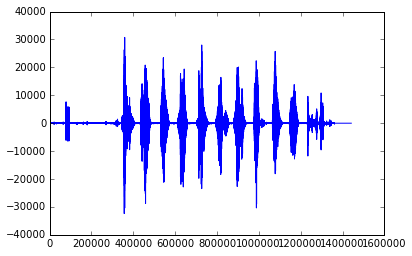

In [3]:
filename = "CML_Recording_Both.wav"
w = wave.open(filename,"rb")

#returns a named tuple (nchannels, sampwidth, framerate, 
# nframes, comptype, compname)
waveParams = w.getparams()

s = w.readframes(waveParams[3])
w.close()
waveArray = np.fromstring(s, np.int16)

pl.figure()
pl.plot(waveArray)

spectrum, freq, bins = mlab.specgram(waveArray, NFFT=256,Fs=waveParams[2],sides='onesided')


In [4]:
# calculates and returns spectrogram of 
def get_wave(filename):
    w = wave.open(filename,"rb")
    waveParams = w.getparams()
    s = w.readframes(waveParams[3])
    w.close()
    waveArray = np.fromstring(s, np.int16)
    return waveArray

# power spectrogram is the absolute value SQUARED of the stft
def get_spectrogram(stft):
    return np.abs(stft)**2

# takes in wave file as input
# win_size is the length of the window in samples
# overlap is the amount of overlap between windows in samples
def my_stft(wave, win_size, overlap):
    # power sinbell analysis window
    win = sinebell(win_size, overlap)
    # make the frames
    frames, wave_pad = make_frames(wave, win, overlap)
    # fft, for each column
    stft = np.fft.fft(frames)
    # keep the spectrum associated with the positive frequencies (potentially times to the upper frequencies)
    if len(win)%2 == 0:
        stft = stft[:int(len(win)/2)+1]
    else:
        stft = stft[:int((len(win)+1)/2)]
    return stft, wave_pad
    
# create sinebell window of length win_size, with overlap, DONE
def sinebell(win_size, overlap):
    win = np.zeros(win_size)
    win[0:overlap] = np.sin( math.pi * (np.array([i for i in range(overlap)])) / (2*(overlap-1)) )
    win[overlap : win_size - overlap] = 1
    win[win_size - overlap:] = np.sin( math.pi * (win_size - np.array([i for i in range(win_size-overlap, win_size)]) - 1 ) / (2*(overlap - 1)) )
    return win

# computes sinebell window with smooth edges, this should be an improvement
def power_sinebell(win_size, overlap):
    win = np.zeros(win_size)
    win[0:overlap] = np.sin( math.pi * (np.array([i for i in range(overlap)])) / (2*(overlap-1)) )**2
    win[overlap : win_size - overlap] = 1
    win[win_size - overlap:] = np.sin( math.pi * (win_size - np.array([i for i in range(win_size-overlap, win_size)]) - 1 ) / (2*(overlap - 1)) )**2
    return win

# x is the input signal, win is the analysis window, overlap
# returns frame matrix and padded input signal x_pad
def make_frames(x, win, overlap):
    win_len = win.shape[0]
    x_len = len(x)
    
    # number of frames
    num_frames = int(np.ceil((x_len + overlap)/(win_len - overlap)))
    
    # initializing zero padded signal
    pad_len = int(overlap + num_frames * (win_len - overlap))
    x_pad = np.zeros(pad_len)
    x_pad[overlap: overlap + x_len] = x
    
    # index of beginning of each frame in x_pad
    frame_ind = np.array([i for i in range(num_frames)]) * (win_len - overlap)
    
    # initialize frames matrix
    frames = np.zeros((win_size, num_frames))
    for i in range(num_frames):
        frames[:,i] = (x_pad[frame_ind[i] : frame_ind[i] + win_size] * win)
    
    return frames, x_pad
    
def my_istft(stft, win_size, overlap):
    # power sinbell analysis window
    win = sinebell(win_size, overlap)
    (num_coeff, num_frames) = stft.shape
    
    # recover full stft by conjugate symmetry of the fourier expansion of real signals
    stft_full = np.zeros((win_size, num_frames), dtype = np.complex128)
    stft_full[:num_coeff,:] = stft
    
    # reasoning: stft[ num_coeff - 1] is the both the negative and positive Nyquist frequency if win_size is even
    # thus, we take the conjugate only of stft[ num_coeff - 2:0:-1 ]
    if win_size%2 == 0:
        stft_full[num_coeff:, :] = np.conj(stft[num_coeff-2:0:-1, :])
    else:
        stft_full[num_coeff:,:] = np.conj(stft[num_coeff-1:0:-1, :])
        
    # take inverse fft of recovered stft
    istft = np.fft.ifft(stft_full)
    # reconstruct padded signal by taking overlap into account
    x_pad = overlap_add(istft, win_size, overlap)
    return x_pad

def overlap_add(signal, win_size, overlap):
    
    win = sinebell(win_size, overlap)
    (temp, num_frames) = signal.shape

    if temp != win_size:
        print("Dimensions of ISTFT are wrong!")
    
    pad_len = overlap + num_frames * (win_size - overlap)
    x_pad = np.zeros(pad_len, dtype = np.complex128)
    
     # index of beginning of each frame in x_pad
    frame_ind = np.array([i for i in range(num_frames)]) * (win_size - overlap)
    
    # do we really need the window again here?
    x_pad[frame_ind[0]:frame_ind[0] + win_size] = signal[:,0] * win
    for i in range(1,num_frames):
        x_pad[frame_ind[i]:frame_ind[i] + win_size] = x_pad[frame_ind[i]:frame_ind[i] + win_size] + signal[:,i] * win
    return x_pad

In [5]:
# epsilon divergence
def compute_obj(v,W,h,eps):
    whv = (np.dot(W,h) + eps)/(v + eps)
    div = whv - np.log(whv) - 1 
    div = np.array(div)
    #print(div.shape)
    return np.sum( div )

# epsilon divergence gradient
def compute_grad(v,W,h,eps):
    grad = np.dot(W.T, (1/(v + eps) - 1/(np.dot(W,h) + eps)))
    return grad

# important! input here has to be the matrix H, not the vector h_t
# this is because we need h_t but also h_(t-1) and h_(t+1)
# ind_t is the index of h_t in H
# lambda is the smoothness constant
def compute_smooth_obj(v,W,H,ind_t,lamb,eps):
    
    # get the column h_t
    h = H[:,ind_t]
    h = h.reshape(h.shape[0],1)
    
    # compute regular objective
    # maybe doing this direct instead of the function call is faster:
    # whv = (np.dot(W,h) + eps)/(v + eps)
    # div = whv - np.log(whv) - 1 
    div = compute_obj(v,W,h,eps)
    
    # compute smoothness terms
    s1 = H[:,ind_t]/H[:,ind_t-1]
    s2 = H[:,ind_t]/H[:,ind_t+1]
    sm = s1 - np.log(s1) - 1
    sm += s2 - np.log(s2) - 1
    # returning properly scaled smooth objective
    return div + lamb * np.sum( sm )
    
# input parameters as above
def compute_smooth_grad(v,W,H,ind_t,lamb,eps):
    
    # get the column h_t
    h = H[:,ind_t]
    h = h.reshape(h.shape[0],1)
    
    # calculates gradient of regular divergence
    div_grad = compute_grad(v,W,h,eps)

    # calculating gradient of smoothness term
    sm_grad = 1/H[:,ind_t-1] + 1/H[:,ind_t+1] - 2/H[:,ind_t]
    sm_grad = sm_grad.reshape(sm_grad.shape[0],1)
    
    # returning properly scaled gradient of smooth objective 
    return div_grad + lamb * sm_grad
    

In [6]:
def grad_checker(v, W, h):
    eps = 1e-3
    (f,k) = W.shape
    t_grad = np.zeros(h.shape)
    for i in range(k):
        ei = np.zeros(h.shape)
        ei[i] = eps
        t_grad[i] = (compute_obj(v,W,h+ei, 1e-12) - compute_obj(v,W,h-ei,1e-12)) / (2*eps)
    print(t_grad)
    print(compute_grad(v,W,h,1e-12))
    
grad_checker(np.random.rand(2,1), np.random.rand(2,2),np.random.rand(2, 1))

[[ 0.373693  ]
 [ 0.02465829]]
[[ 0.3736934 ]
 [ 0.02465864]]


In [7]:
# second grad checker for smooth objective functions: Works!
def grad_checker(v,W,H,ind_t,lamb,eps):
    eps_dif = 1e-3
    (f,k) = W.shape
    t_grad = np.zeros(H[:,ind_t].shape)
    for i in range(k):
        ei = np.zeros(H.shape)
        ei[i,ind_t] = eps_dif
        t_grad[i] = (compute_smooth_obj(v,W,H+ei,ind_t,lamb,eps) - compute_smooth_obj(v,W,H-ei,ind_t,lamb,eps)) / (2*eps_dif)
    print(t_grad)
    print(compute_smooth_grad(v,W,H,ind_t,lamb,eps))
grad_checker(np.random.rand(2,1), np.random.rand(2,2),np.random.rand(2, 3),1,1,1e-12)

[-2.16958254 -2.30892864]
[[-2.16956602]
 [-2.30891368]]


In [8]:
def gradient_backtracking(v, W, h, max_iter, compute_grad, compute_obj, eps):
    
    v = v.reshape(v.shape[0],1)
    h = h.reshape(h.shape[0],1)
    beta = 0.2 #backstep factor between 0.1 and 0.8
    opt_prec = 1-1e-6 # optimization precision
    eta = 1e-1 #initial step size
    
    #obj = [None]*max_iter
    
    max_backstep = 25 # maximum number of backsteps
    t = 0 # backstepping counter
    k = 0 # gradient step counter 
    
    old_obj = compute_obj(v,W,h,eps)

    while( k < max_iter and t != max_backstep ):
        
        grad = compute_grad(v,W,h,eps)
        #obj[k] = compute_obj(v,W,h,eps)
        
        t = 0 # reset backstepping counter
        eta = 1/beta*eta # try to increase stepsize slightly again
        
        # make sure h-n*grad is positive
        while(any(h - eta * grad < 0)  and t < max_backstep ):
            t += 1
            eta = beta * eta
    
        new_obj = compute_obj(v,W,(h - eta*grad),eps)
        
        while( new_obj > opt_prec * old_obj and t < max_backstep):
            t += 1
            eta = beta * eta
            new_obj = abs(compute_obj(v,W,(h - eta*grad),eps))
                      
        h = h - eta * grad # update h according to gradient step
        k += 1 # update gradient step counter
        old_obj = new_obj
        
    h = h.reshape(h.shape[0],)
    return h

h = gradient_backtracking(np.random.rand(10,1), np.random.rand(10,2),  np.random.rand(2, 1), 100, compute_grad, compute_obj, 1e-12)


In [9]:
#index = [i for i in range(10)]
#plt.title("On training data")
#plt.plot([i for i in range(len(obj))], obj)


In [12]:
def online_nmf(spectrum, W, H,A, B, rho, beta, eta, eps):
           
    a = np.zeros(W.shape)
    b = np.zeros(W.shape)
    
    t = 1
    W_old = W + 1.5*eta
    k = W.shape[1]
    h = np.random.rand(W.shape[1],)
    n = spectrum.shape[1]
    cost = []
    cost.append(compute_obj(spectrum,W,H,eps))
    
    while np.linalg.norm(W - W_old, ord = "fro") > eta:
        
        t = t+1 
        
        ind = random.randint(0, n-1)
        v = spectrum[:,ind]
    
        h = gradient_backtracking(v, W, H[:,ind], 100, compute_grad, compute_obj, eps)
        
        H[:, ind] = h
       
        h = h.reshape(h.shape[0],1)
        v = v.reshape(v.shape[0],1)
        den = eps + np.dot(W, h)
        
        a += np.dot(((eps+v)/(den)**2), h.T) * np.square(W) 
        
        b += np.dot(1/den, h.T)
       
        if t % beta == 0:
            A = A + rho*a
            a = 0
            B = B + rho*b
            b = 0
            W_old = W
            W = np.sqrt(A/B)
            
            for i in range(k):
                s = np.sum(W[:,i])
                W[:,i] = W[:,i]/s
                A[:,i] = A[:,i]/s
                B[:,i] = B[:,i]*s
                #print(i)

            #print(np.linalg.norm(compute_obj(spectrum,W_old,H,eps))- compute_obj(spectrum,W,H,eps)) 
            gc.disable()
            cost.append(compute_obj(spectrum,W,H,eps))
            gc.enable()
            
        #cost.append(compute_obj(spectrum,W,H,eps))
        if t > 100*n:
            print(" W shape" , W.shape)
            break

        #print("W", np.linalg.norm(W[:,1]))
        #print("H", np.linalg.norm(H[1]))
        #print(compute_obj(spectrum,W,H.T,eps))
        
    print("t" , t)
    return W, H, cost


In [13]:
np.linalg.norm(spectrum[:,4])

9.9288495889693049

In [51]:
eps = 1e-12
v = spectrum.T[0]
K = 10
W = abs(np.random.randn(spectrum.shape[0],K) + np.ones((spectrum.shape[0],K)))
H = np.zeros((K, spectrum.shape[1]))
#abs(np.random.randn(K, spectrum.shape[1]) + np.ones((K, spectrum.shape[1])))

A = np.zeros(W.shape)
B = np.zeros(W.shape)

r = 1
beta = 100
rho = r**(beta/spectrum.shape[1])
W, H, cost = online_nmf(spectrum, W, H, A, B, rho, beta, 1e-4, eps)

t 54600


In [ ]:
import cProfile
cProfile.run('online_nmf(spectrum, W, H, A, B, 1, 100, 1e-2, eps)')

In [278]:
change = []
for i in range(1, len(cost)):
    change.append(np.linalg.norm(cost[i]-cost[i-1]))

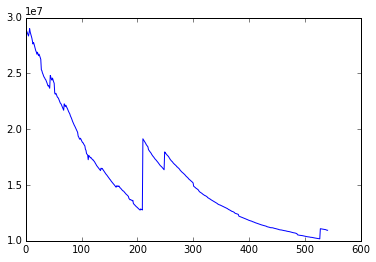

In [52]:
plt.plot([i for i in range(len(cost[5:]))], cost[5:])

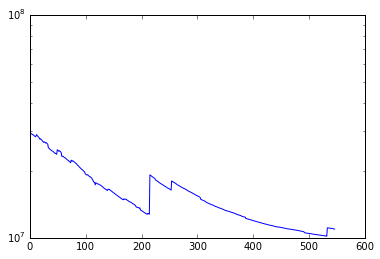

In [53]:
plt.semilogy([i for i in range(len(cost))], cost)

In [141]:
W.shape

(129, 10)

In [142]:
H.shape

(10, 11263)

In [143]:
spectrum.shape

(129, 11263)

In [31]:
def get_closest(x, centers):
    distances = []
    
    #get the distance from the point(x) to every centroid
    #and get the index of centroid that yields 
    #the minimum distance 
    
    for mu in centers:
        distances.append(np.linalg.norm(x-mu))
    index = np.argmin(distances)
    
    return index, min(distances)

def k_means_objective(X, k, C, centers):
    
    sum_distance = 0
    for j in range(k):
        for x in X[C==j]:
            sum_distance += (np.linalg.norm(x-centers[j]))**2
                
    return sum_distance

In [40]:
def mini_batch(X, k, b, max_iter):
    v = [0]*k
    centers = np.array(random.sample(list(X), k))
    distortion = []
  
    for i in range(max_iter):
        M = np.array(random.sample(list(X),b))
        C=[0]*len(M)
        for i,x in enumerate(M): 
            index = get_closest(x, centers)[0]
            C[i] = index
      
        
        for i, x in enumerate(M):
            index = C[i]
            v[index]+=1
            n = 1/v[index]
    
            centers[index] = (1- n)*centers[index] + n*x
        '''
        D=[0]*len(X)
        for i in range(len(X)): 
            index = get_closest(X[i], centers)[0]
            D[i] = index
        
        D = np.array(D)
        
        distortion.append(k_means_objective(X, k, D, centers))
        '''
            
    return centers

In [41]:
K = 10
centers = mini_batch(spectrum.T, K, 100, 100)
centers = np.array(centers)
W2 = centers.T

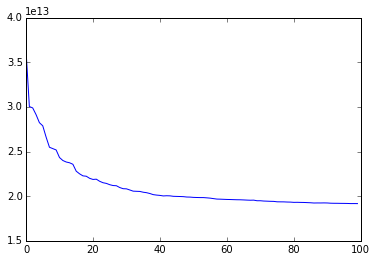

In [238]:
plt.plot([i for i in range(len(distortion))], distortion)

In [54]:

v2 = spectrum[:,0]

H2 = np.zeros((K, spectrum.shape[1]))

A2 = np.zeros(W2.shape)
B2 = np.zeros(W2.shape)

eps = 1e-12
r = 1
beta = 100
rho = r**(beta/spectrum.shape[1])
W2, H2, cost2 = online_nmf(spectrum, W2, H2, A2, B2, rho, beta, 1e-5, eps)

 W shape (129, 10)
t 112631


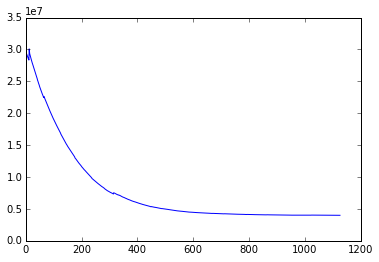

In [55]:
plt.plot([i for i in range(len(cost2))], cost2)

In [184]:
compute_obj(spectrum,W2,H2,eps)

27393387.803380556

In [214]:
X = [[1,2,3], [4,5,6]]

In [215]:
np.square(X)

array([[ 1,  4,  9],
       [16, 25, 36]])